# Neuronale Netzwerke - Bilderkennung

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as dt
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Nur einmalig ausführen:

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
dataset = torchvision.datasets.Caltech101(root="./data", download=True, transform=transform)

Files already downloaded and verified


Zur Erkennung von Bildern fällt meine Auswahl auf die Bilder eines Bassfisches und eines Akkordions.Dazu verwende ich den torchvision Datensatz CIFAR10. 
(https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

In [3]:
transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])

batch_size = 4
data_dir = "./data/caltech101/101_ObjectCategories/input_data"

data = torchvision.datasets.ImageFolder(root=data_dir, transform=transform)

train_size = int(0.7 * len(data))
test_size = len(data) - train_size
generator = torch.Generator().manual_seed(42)
sets = dt.random_split(data, [0.7, 0.3], generator=generator)
train_dataset = sets[0]
test_dataset = sets[1]


train_loader = dt.DataLoader(train_dataset, batch_size, shuffle=True)
test_loader = dt.DataLoader(test_dataset, batch_size, shuffle=True)

# Change the classes accordingly
classes = ('accordion', 'bass')

Im oberen Code-Snippet lade ich Fotos von Bassfischen und Delfinen. Achtung: Der ImageFolder erwartet, dass in dem angegebenen Pfad nochmal ein Folder ist, wo die Bilder drinnen sind, deswegen habe ich alle Fotos in einen img-Folder (jeweils für Bassfische und Delfine) kopiert, um keinen Error zu kriegen. 

77
32


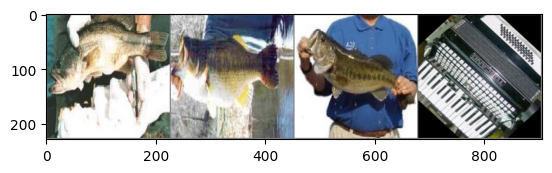

bass  bass  bass  accordion


In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
dataiter = iter(test_loader)
images, labels = next(dataiter)
print(len(train_dataset))
print(len(test_dataset))

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

Im oberen Code-Snippet überprüfe ich, ob ich die Daten auch richtig habe. Ich hatte große Probleme damit, diese Daten gescheit zu managen. Ich hatte sehr lange als Labels nur 'Bass' stehen, obwohl ein paar Bilder Delfine waren. Meine Lösung dazu war, alle Bilder in einen einzigen Ordner zu packen (in dem Fall bass) und dort zwei img Folder zu haben, wo in einem die Bass-Fotos und im anderen die Delfin-Fotos da sind. Damit muss man kein Concat-Dataset benutzen, was mir nur Probleme bereitet hat.

In [5]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(44944, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Diese Klasse ist ein CNN mit 2 Convolutional Layers.

In [6]:
for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

Finished Training


Hier trainieren wir unser Net n Epochen mit den Trainingsdaten.

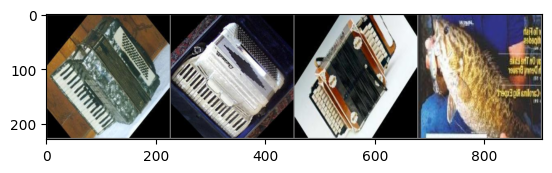

GroundTruth:  accordion accordion accordion bass 
Predicted:  accordion accordion accordion bass 


In [11]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

net = Net()
net.load_state_dict(torch.load(PATH))

outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Hier können wir einfache Predictions ausführen und schauen, wie oft das Net richtig liegt.

In [14]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 96 %


Hier geben wir die Accuracy des Modells aus.

In [15]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: accordion is 94.1 %
Accuracy for class: bass  is 100.0 %


Hier wird die Accuracy für jede Klasse berechnet.

## Findings:

Das Netz wurde mit Bassfischen und Delfinen ebenso probiert. In dem Fall war die Accuracy aber niedriger, da die Fotos teilweise relativ ähnlich waren. Außerdem konnte festgestellt werden, dass die Accuracy sich asymptotisch einem Wert nähert. Wenn noch mehr Klassen miteinbezogen werden sollen, muss einfach nur in den Input-Folder eine anderer Foto-Ordner hineinkopiert werden und die classes dementsprechend erweitert werden (auf die Reihenfolge der Labels achten!). Have fun!